In [1]:
!pip install focal-loss==0.0.2

In [2]:
import pandas as pd
import numpy as np
import skopt
import gc
import time
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
import matplotlib.pyplot as plt
from skopt.plots import plot_convergence,plot_objective,plot_evaluations
import warnings
import random
import tensorflow as tf
from tensorflow.keras import Model
from focal_loss import BinaryFocalLoss
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv1D, Input, Dropout, BatchNormalization, MaxPooling1D, Flatten, Dense, GlobalMaxPooling1D
from skopt import dump, load
warnings.filterwarnings("ignore")

In [3]:
AUTO = tf.data.experimental.AUTOTUNE
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:
def pT_classes(x):
    if x<=25:
        return 0
    else:
        return 1

df = pd.read_csv('../input/cmsdata/CMS_trigger.csv').drop(columns=['Unnamed: 0'])
df['No. of hits'] = df[['Mask_'+str(i) for i in range(12)]].sum(axis = 1)
df = df[df['No. of hits']<9].reset_index(drop=True)
df['1/pT'] = df['q/pt'].abs()
df['pT'] = 1/df['1/pT']
df['pT_classes'] = df['pT'].apply(pT_classes)

features = list(np.array([['Phi_'+str(i),'Theta_'+str(i)] for i in range(12)]).reshape((-1)))
labels_1 = ['1/pT']
labels_2 = ['BendingAngle_'+str(i) for i in [0,1,9,10,11]]
labels_3 = ['pT_classes']
labels_4 = ['PatternStraightness']

scaler_1 = StandardScaler()
df[features] = scaler_1.fit_transform(df[features])
df[features] = df[features].fillna(0)

scaler_2 = MinMaxScaler()
df[labels_2] = scaler_2.fit_transform(df[labels_2])
df[labels_2] = df[labels_2].fillna(0)

scaler_3 = MinMaxScaler()
df[labels_4] = scaler_3.fit_transform(df[labels_4])
df[labels_4] = df[labels_4].fillna(0)

features = list(np.array([['Phi_'+str(i),'Theta_'+str(i), 'Mask_'+str(i)] for i in range(12)]).reshape((-1)))

df = df.sample(frac = 0.4).reset_index(drop = True)
df = df.iloc[:int((len(df)//1024)*1024)]

In [5]:
X_train = df[features].iloc[:int(len(df)*0.8)].to_numpy().reshape((-1,12,3))
Y1_train = df[labels_1].iloc[:int(len(df)*0.8)]
Y2_train = df[labels_2].iloc[:int(len(df)*0.8)]
Y3_train = df[labels_3].astype('float32').iloc[:int(len(df)*0.8)]
Y4_train = df[labels_4].iloc[:int(len(df)*0.8)]

X_test = df[features].iloc[int(len(df)*0.8):].to_numpy().reshape((-1,12,3))
Y1_test = df[labels_1].iloc[int(len(df)*0.8):]
Y2_test = df[labels_2].iloc[int(len(df)*0.8):]
Y3_test = df[labels_3].astype('float32').iloc[int(len(df)*0.8):]
Y4_test = df[labels_4].iloc[int(len(df)*0.8):]

df = 0

In [6]:
X_train.shape, len(Y1_train), len(Y2_train), len(Y3_train), len(Y4_train), X_test.shape, len(Y1_test)

((1024819, 12, 3), 1024819, 1024819, 1024819, 1024819, (256205, 12, 3), 256205)

In [7]:
# Real - Dropout, Focal loss weight, SkipFraction
# Binary - Batchnorm, skipType
# Integer - number of layers, number of filters, focal loss gamma, number of dense neurons

In [8]:
space  = [Real(0.0, 0.7, name='Dropout'),
          Real(0.0, 1.0, name='FocalLossWeight'),
          Real(0.0, 1.0, name='SkipFraction'),
          Categorical([0,1], name = 'BatchNorm'),
          Categorical([0,1], name = 'SkipType'),
          Integer(2, 10, name='# Layers'),
          Integer(16, 512, name='# Filters'),
          Integer(0, 5, name='FocalLossGamma'),
          Integer(128, 512, name='DenseNeurons'),
         ]

In [9]:
def cnn(values = [0,1,0.5,1,1,5,16,2,128], X_train = X_train, Y1_train = Y1_train, Y2_train = Y2_train, Y3_train = Y3_train, Y4_train = Y4_train):
    global strategy
    dropout = values[0]
    FocalLossWeight = values[1]
    SkipFraction = values[2]
    batchNorm = values[3]
    SkipType = values[4]
    Layers = values[5]
    Filters = values[6]
    Gamma = values[7]
    DN = values[8]
    
    batch_size=1024* strategy.num_replicas_in_sync
    path = "model.h5"
    
    with strategy.scope():
        I = Input(shape=(12,3))
        x = Conv1D(filters=Filters, kernel_size=3, activation='relu', padding='same')(I)
        x_ = x
        for i in range(Layers-1):
            x = Dropout(dropout)(x)
            if batchNorm==1:
                x = BatchNormalization()(x)
            x__ = Conv1D(filters=Filters, kernel_size=3, activation='relu', padding='same')(x)
            if SkipType==1 and Layers*(1-SkipFraction)<=i:
                x = tf.concat([x_, x__] ,axis = -1)
                x_ = x__
            elif SkipType==0 and Layers*(1-SkipFraction)<=i:
                x = x_ + x__
                x_ = x__
            else:
                x_ = x__
                x = x__
        x = GlobalMaxPooling1D()(x)
        x1 = Dense(DN, activation='relu')(x)
        O1 = Dense(1, activation='sigmoid')(x1)
        x2 = Dense(DN, activation='relu')(x)
        O2 = Dense(5, activation='sigmoid')(x2)
        x3 = Dense(DN, activation='relu')(x)
        O3 = Dense(1, activation='sigmoid')(x3)
        x4 = Dense(DN, activation='relu')(x)
        O4 = Dense(1, activation='sigmoid')(x4)

        model = Model(inputs=I, outputs=[O1,O2, O3, O4])

        checkpoint = ModelCheckpoint(path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
        early_stop = EarlyStopping(monitor='val_loss',patience=3,verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=0,verbose=0)

        model.compile(optimizer = 'adam', loss=['mse','mse',BinaryFocalLoss(gamma=Gamma),'mse'],loss_weights = [1,1,1,FocalLossWeight] )
    
#     model.summary()
#     print(X_train.shape, Y1_train.shape, Y2_train.shape, Y3_train.shape, Y4_train.shape )
    model.fit(x = X_train, y = [Y1_train, Y2_train, Y3_train, Y4_train], batch_size=batch_size, epochs=40, verbose=0, validation_split=0.1, callbacks=[checkpoint,early_stop,reduce_lr])
    
    model.load_weights(path)
    
    return model

In [10]:
def score(true, preds):
    true = 1/true
    preds = 1/(preds+pow(10,-6))
    S = []
    count = 0
    for i in range(150):
        try:
            S.append(mae(true[(true>i)&(true<=i+1)],preds[(true>i)&(true<=i+1)]))
        except:
            count+=1
            continue
    print(count)
    return sum(S)

In [11]:
iteration__ = 0
def objective(values = [0,1,0.5,1,1,5,16,2,128], X_test = X_test, Y1_test = Y1_test, Y2_test = Y3_test, Y3_test = Y3_test, Y4_test = Y4_test):
    global iteration__
    start = time.time()
    iteration__ += 1
    gc.collect()
    model = cnn(values)
    test_preds = model.predict(X_test)[0]
    if len(set(list(test_preds.reshape((-1)))))==1:
        model = cnn(values)
        test_preds = model.predict(X_test)[0]
    loss = score(Y1_test.to_numpy(), test_preds)
    print(iteration__, "iteration loss = ", loss)
    print('Time-taken = ', time.time()-start)
    print()
    return loss

In [12]:
x0 = []
y0 = np.array([])
for i in range(1,-1,-1):
    res = load('../input/bayesian1/result'+str(i)+'.pkl')
    x0 = x0 + res.x_iters
    y0 = np.concatenate([y0,res.func_vals])
    
for i in range(2):
    res = load('../input/bayesian2/result'+str(i)+'.pkl')
    x0 = x0 + res.x_iters[40:]
    y0 = np.concatenate([y0,res.func_vals[40:]])

In [13]:
res_gp = gp_minimize(objective, space, n_calls=50, x0=x0, y0=y0, n_random_starts=5)

"Best score=%.4f" % res_gp.fun

2
1 iteration loss =  4215.9465535369945
Time-taken =  259.14762234687805

2
2 iteration loss =  13599.92466389158
Time-taken =  336.0672552585602

2
3 iteration loss =  4670.725113557313
Time-taken =  163.61497330665588

2
4 iteration loss =  7180.561804407929
Time-taken =  183.9500925540924

2
5 iteration loss =  8627.153337311222
Time-taken =  172.45716309547424

2
6 iteration loss =  4501.688431614183
Time-taken =  190.5146837234497

2
7 iteration loss =  4624.15188949729
Time-taken =  181.2258484363556

2
8 iteration loss =  734756.722161909
Time-taken =  105.71916270256042

2
9 iteration loss =  4496.220221233235
Time-taken =  170.3350009918213

2
10 iteration loss =  5223.621350827795
Time-taken =  193.09661388397217

2
11 iteration loss =  5693.356397513544
Time-taken =  192.4307243824005

2
12 iteration loss =  5388.216382702827
Time-taken =  145.04450607299805

2
13 iteration loss =  8015.460392901957
Time-taken =  166.15598583221436

2
14 iteration loss =  147982121.7007789


'Best score=4215.9466'

In [14]:
# res_gp = gp_minimize(objective, space, n_calls=20, n_random_starts=5)

# "Best score=%.4f" % res_gp.fun

In [15]:
x0 = res_gp.x_iters
y0 = res_gp.func_vals

for i in sorted(y0):
    print(i, x0[np.where(y0==i)[0][0]])

4215.9465535369945 [0.18813146036324027, 0.09836660889581819, 0.021271825523129454, 1, 1, 10, 502, 4, 287]
4397.3098541090685 [0.18743132758774728, 0.3768178382499212, 0.7498881415077308, 0, 0, 8, 310, 2, 386]
4456.423208057392 [0.28838549095879223, 0.5019331621708117, 0.811977489189331, 0, 1, 8, 333, 4, 447]
4496.220221233235 [0.08809848434316019, 0.7945612111520277, 0.6425705116958242, 0, 1, 8, 293, 4, 384]
4501.688431614183 [0.11584268846490228, 0.7669915600095816, 0.6350352099780308, 0, 1, 9, 234, 3, 442]
4516.583418093739 [0.09324822042088042, 0.6534378748002998, 0.45602523535473194, 1, 0, 6, 105, 4, 368]
4624.15188949729 [0.3847586103012645, 0.9277410716401285, 0.32473510292913593, 0, 1, 7, 332, 2, 374]
4629.756744934709 [0.29053033600045747, 0.7140276231852861, 0.44909181010190835, 1, 0, 8, 226, 3, 336]
4661.824818612379 [0.026008517983544137, 0.7757291014978356, 0.9991521819491225, 1, 1, 9, 113, 3, 440]
4670.725113557313 [0.42648978510508484, 0.5072195739701614, 0.1031911628773

In [16]:
dump(res_gp, 'result.pkl')

In [17]:
print("Best parameters:")
print("- Dropout=",res_gp.x[0])
print("- FocalLossWeight=",res_gp.x[1])
print("- SkipFraction=",res_gp.x[2])
print("- BatchNorm=",res_gp.x[3])
print("- SkipType=",res_gp.x[4])
print("- # Layers=",res_gp.x[5])
print("- # Filters=",res_gp.x[6])
print("- FocalLossGamma=",res_gp.x[7])
print("- DenseNeurons=",res_gp.x[8])

Best parameters:
- Dropout= 0.18813146036324027
- FocalLossWeight= 0.09836660889581819
- SkipFraction= 0.021271825523129454
- BatchNorm= 1
- SkipType= 1
- # Layers= 10
- # Filters= 502
- FocalLossGamma= 4
- DenseNeurons= 287


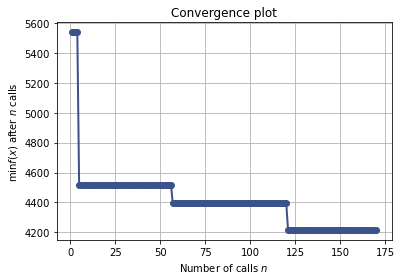

In [18]:
plot_convergence(res_gp)
plt.show()

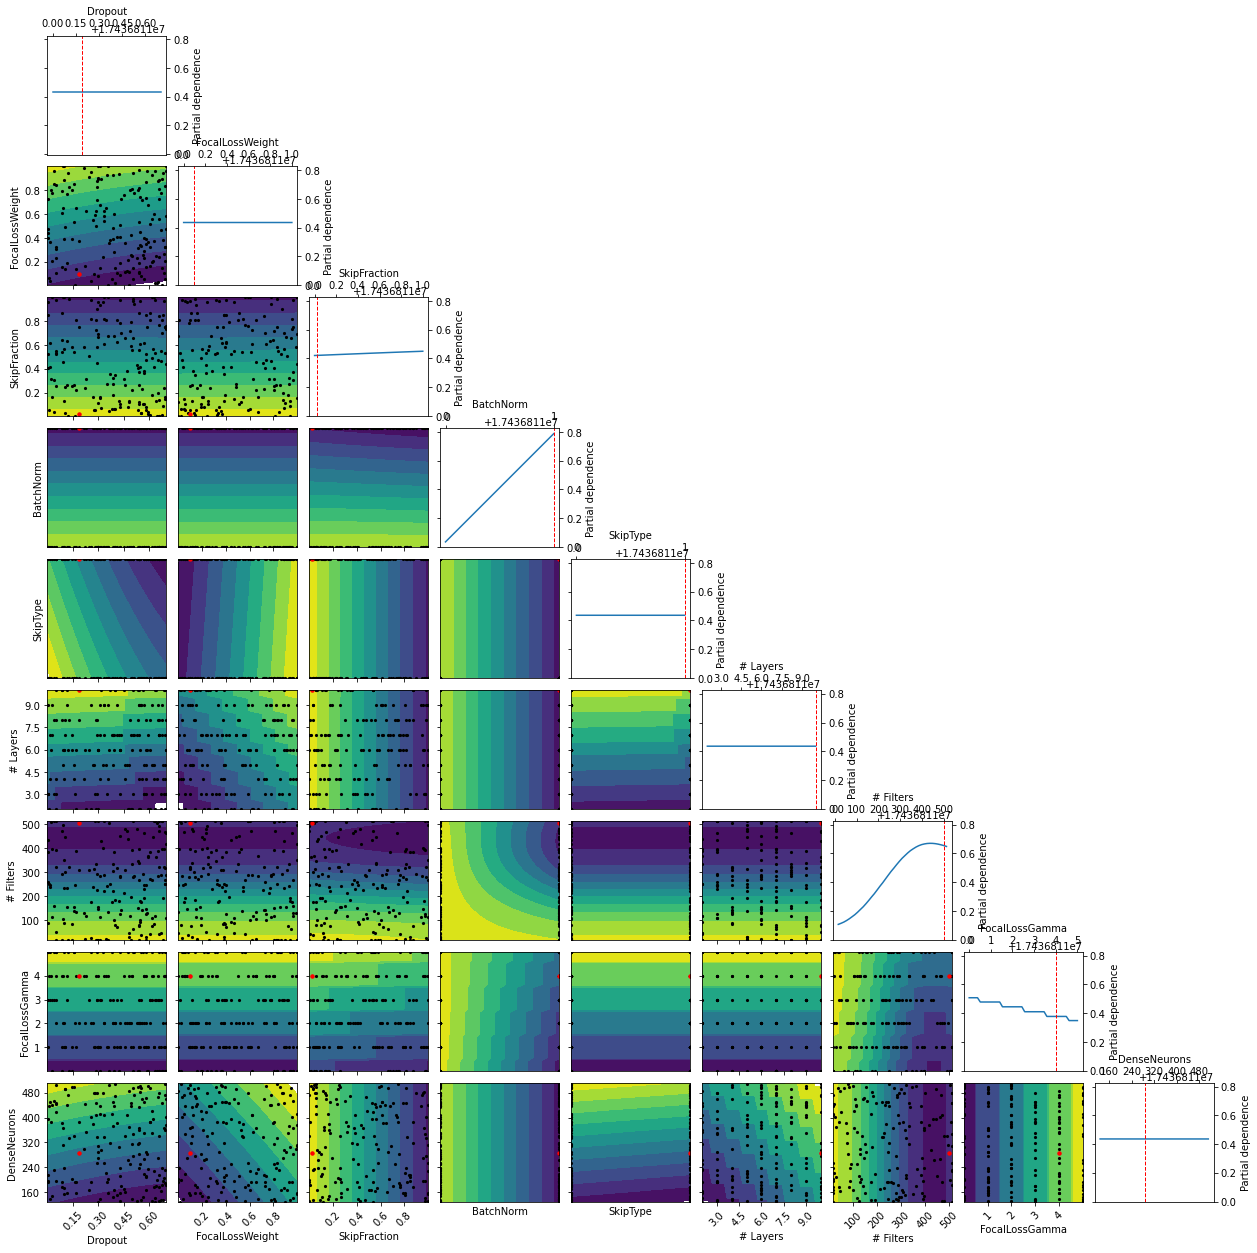

In [19]:
plot_objective(res_gp)
plt.show()

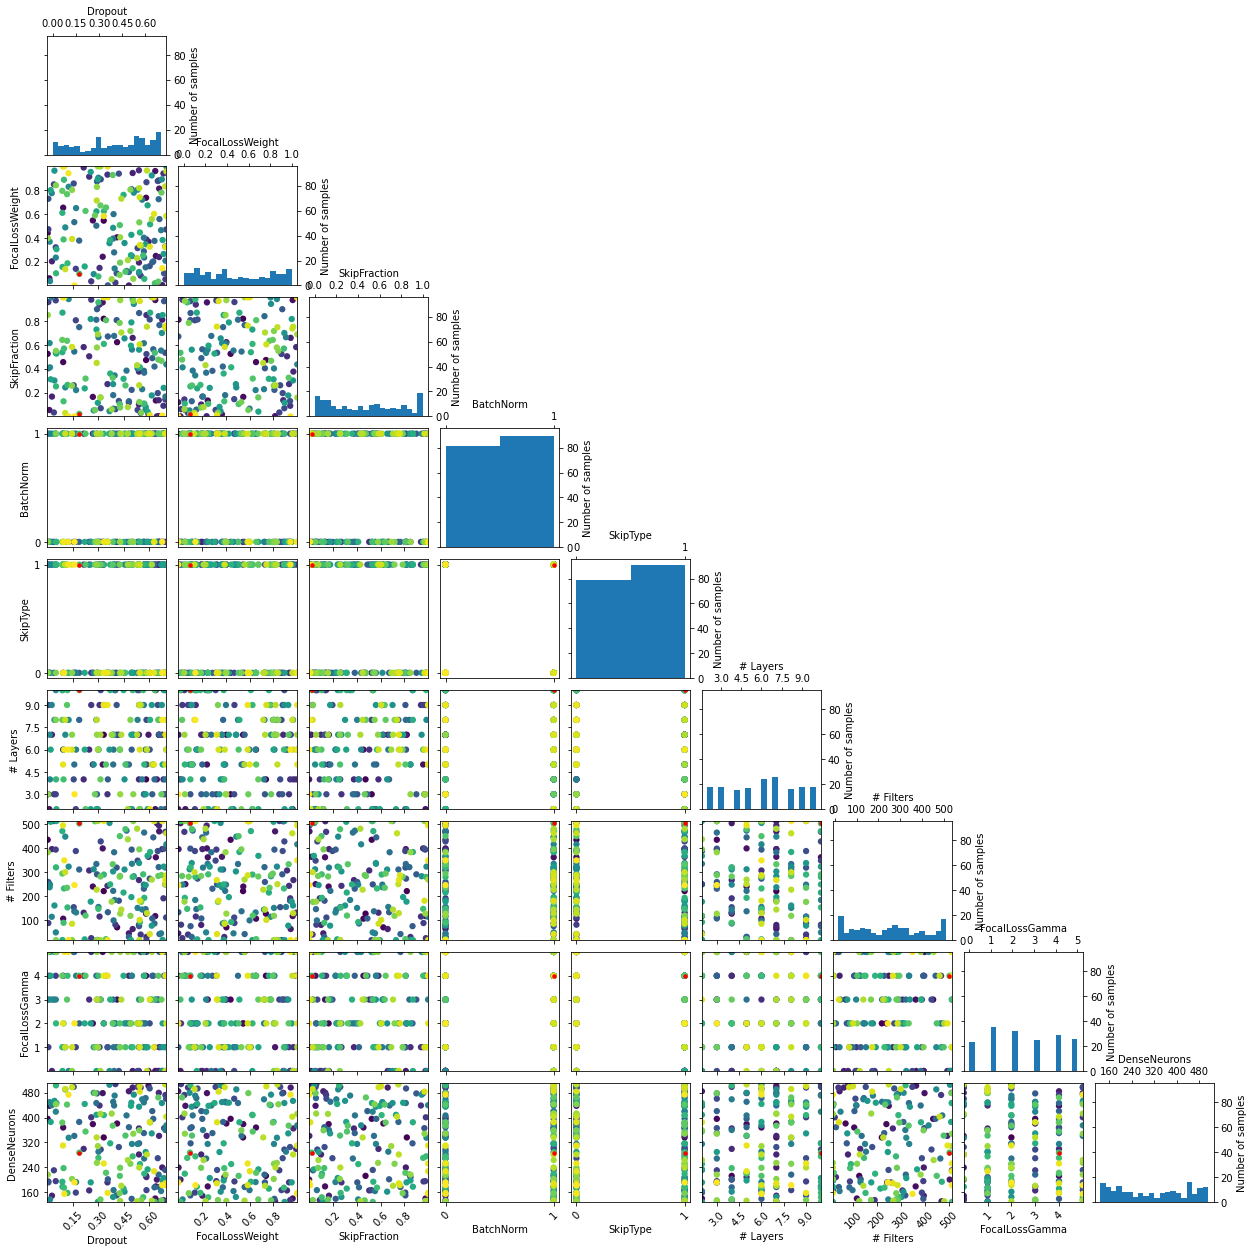

In [20]:
plot_evaluations(res_gp)
plt.show()

In [21]:
res_loaded = load('result.pkl')

In [22]:
res_loaded.fun

4215.9465535369945